<a href="https://colab.research.google.com/github/kessingtonosazee/GCP_Project_1/blob/master/Copy_of_aml_2324_w6_pdp_ice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Partial Dependence (PDP) / Individual Conditional Expectation (ICE) Plots

## Import Packages and Set Up Environment

In [ ]:
!pip install --upgrade scikit-learn==1.4.0 -q
!pip install --upgrade category_encoders -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 54.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.1 MB/s eta 0:00:00


In [ ]:
import sklearn
sklearn.set_config(transform_output="pandas")

%config InlineBackend.figure_format = 'retina'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
    { "figure.figsize": (6, 4) }, style='ticks', color_codes=True, font_scale=0.8
)

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import GridSearchCV, ParameterGrid, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures

from sklearn.ensemble import RandomForestRegressor

## Dataset: Wine Quality, Regression

In [ ]:
url = 'https://raw.githubusercontent.com/gerberl/6G7V0017-2324/main/datasets/winequality-white.csv'
wine = pd.read_csv(url, sep=';')
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [ ]:
y = wine['quality']
X = wine.drop('quality', axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.2, random_state=0
)

## Reusable Pre-Processing and Model Fitting Pipelines

In [ ]:
def create_pp_ppln(X, scaling=False, poly=False):
    """creates a default preprocessing pipeline for numeric and categorical data
    using simple imputers, scalers, and encoders. It relies on latest versions
    of sklearn so as to produce pandas outputs.

    X: the dataset with the features (needed for feature names)

    returns the Pipeline object
    """

    numeric_features = X.select_dtypes(exclude='object').columns.tolist()
    numeric_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="mean"))
        ]
    )

    if scaling:
        numeric_transformer.steps.extend([
            ("scaler", MinMaxScaler())
        ])
    if poly:
        numeric_transformer.steps.extend([
            ('poly', PolynomialFeatures(include_bias=False))
        ])


    categorical_features = X.select_dtypes(include='object').columns.tolist()
    categorical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("enc", TargetEncoder()),
        ]
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features),
        ],
        remainder='passthrough',
        verbose_feature_names_out=False
    )

    return preprocessor

In [ ]:
def create_est_ppln(est, X, scaling=False, poly=False):
    """ """
    est_pipe = Pipeline(
        steps=[
            ("pp", create_pp_ppln(X, scaling, poly)),
            ("est", est)
        ]
    )

    return est_pipe

## Model Fitting

* a default Random Forest regressor `rfr`.

In [ ]:
rfr  = create_est_ppln(RandomForestRegressor(max_depth=8), X_train)

In [ ]:
rfr.fit(X_train, y_train)

Pipeline(steps=[('pp',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['fixed acidity',
                                                   'volatile acidity',
                                                   'citric acid',
                                                   'residual sugar',
                                                   'chlorides',
                                                   'free sulfur dioxide',
                                                   'total sulfur dioxide',
                                                   'density', 'pH', 'sulphates',
                                                   'alcohol']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('enc',
                                                                   TargetEncoder())]),
                                                  [])],
                                   verbose_feature_names_out=False)),
                ('est', RandomForestRegressor(max_depth=8))])

In [ ]:
eval_results = cross_validate(
    rfr, X_train, y_train, cv=5,
    scoring='neg_mean_absolute_error',
    return_train_score=True
)
(
    (-eval_results['test_score'].mean(), eval_results['test_score'].std(),
    -eval_results['train_score'].mean(), eval_results['train_score'].std())
)

(0.5172170244772992,
 0.009404849829805488,
 0.42455063131948945,
 0.005237403240615753)

## Visualising Predictions as A Function of A Feature

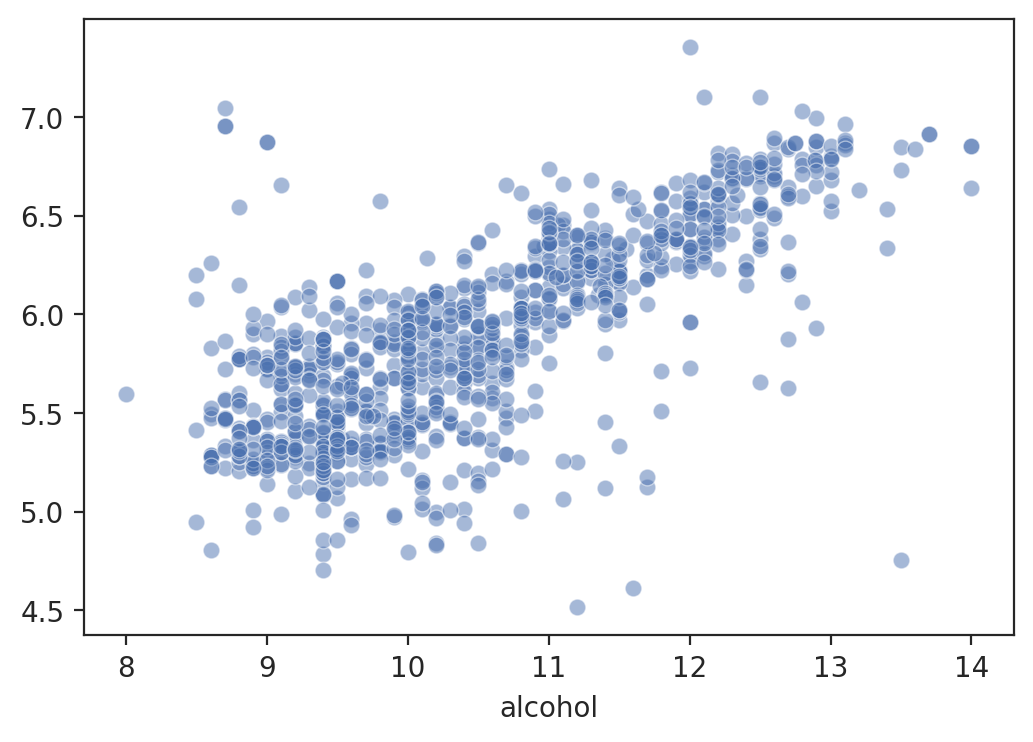

In [ ]:
sns.scatterplot(x=X_test['alcohol'], y=rfr.predict(X_test), alpha=0.5);

### Key Points:

* What is typical prediction for a subregion of the data?
* What happens in regions of data underpresented by the test data?



## Enters Partial Dependence (PDP) and Individual Conditional Expectation (ICE) Plots

* Alongside SHAP, some of my favourite techniques/tools for making sense of complex and/or opaque models.

* **ICE**: Assume that we would like to explore a counterfactual scenario. Pick an observation (e.g., patient 0 in Diabetes dataset). Model's prediction is `yes` (onset of diabetes within a particular period) with probability 0.7. What happens if I change BMI from 25 to 30? How would the target be affected? And beyond - let us see what happens for the whole range of BMI (say, 15 to 40) for that observation, while keeping everything else fixed. The curve we get of predict target against BMI is an **ICE**.

* **PDP**: Pick the average ICE from all ICE produced for the feature (or pair of features) and observation.

* Caveats:
    - Computationally expensive - need shortcuts/optimisation.
    - We are looking at a single feature or pair of features, normally. It averages effects across all remaining features.
    - Traditional way of generating synthetic data may create non-sensical data points (e.g., a small house with 40 bedrooms).


### Individual Conditional Expectation (ICE): Behind the Scenes

* **WARNING**: This section is for teaching purposes only, for gaining an intuition of how ICEs work and how synthetic data is produced. You would not need this for practice ICE work, as you can rely on `sklearn` and other packages to do this on your behalf.

Let us investigate the effect of **alcohol** across the whole range, creating synthetic data from existing instances in the data, according to your ML model.

An ICE focuses on a single feature and observation!

In [ ]:
X_train['alcohol'].min(), X_train['alcohol'].max()

(8.0, 14.2)

In [ ]:
temp_synth_data = np.linspace(X_train['alcohol'].min(), X_train['alcohol'].max(), 100)
temp_synth_data[:5], temp_synth_data[-5:]

(array([8.        , 8.06262626, 8.12525253, 8.18787879, 8.25050505]),
 array([13.94949495, 14.01212121, 14.07474747, 14.13737374, 14.2       ]))

Let us pick an random observation, from which we will produce synthetic ones by varying `temp` across its range.

In [ ]:
ex_instance = X_test.sample(1, random_state=42).drop(columns='alcohol')
ex_instance

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates
849,6.0,0.2,0.24,1.8,0.03,30.0,105.0,0.9909,3.31,0.47


In [ ]:
temp_synth_df = pd.DataFrame(temp_synth_data, columns=['alcohol'])
temp_synth_df.head()

,alcohol
0,8.000000
1,8.062626
2,8.125253
3,8.187879
4,8.250505


In [ ]:
synth_df = ex_instance.merge(temp_synth_df, how='cross')
print(synth_df.shape)
synth_df

(100, 11)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,6.0,0.2,0.24,1.8,0.03,30.0,105.0,0.9909,3.31,0.47,8.000000
1,6.0,0.2,0.24,1.8,0.03,30.0,105.0,0.9909,3.31,0.47,8.062626
2,6.0,0.2,0.24,1.8,0.03,30.0,105.0,0.9909,3.31,0.47,8.125253
3,6.0,0.2,0.24,1.8,0.03,30.0,105.0,0.9909,3.31,0.47,8.187879
4,6.0,0.2,0.24,1.8,0.03,30.0,105.0,0.9909,3.31,0.47,8.250505
...,...,...,...,...,...,...,...,...,...,...,...
95,6.0,0.2,0.24,1.8,0.03,30.0,105.0,0.9909,3.31,0.47,13.949495
96,6.0,0.2,0.24,1.8,0.03,30.0,105.0,0.9909,3.31,0.47,14.012121
97,6.0,0.2,0.24,1.8,0.03,30.0,105.0,0.9909,3.31,0.47,14.074747
98,6.0,0.2,0.24,1.8,0.03,30.0,105.0,0.9909,3.31,0.47,14.137374


In [ ]:
pred = rfr.predict(synth_df)
pred[:5], pred[-5:]

(array([5.79296019, 5.79296019, 5.79296019, 5.79296019, 5.79296019]),
 array([6.74554142, 6.74554142, 6.74554142, 6.74554142, 6.74554142]))

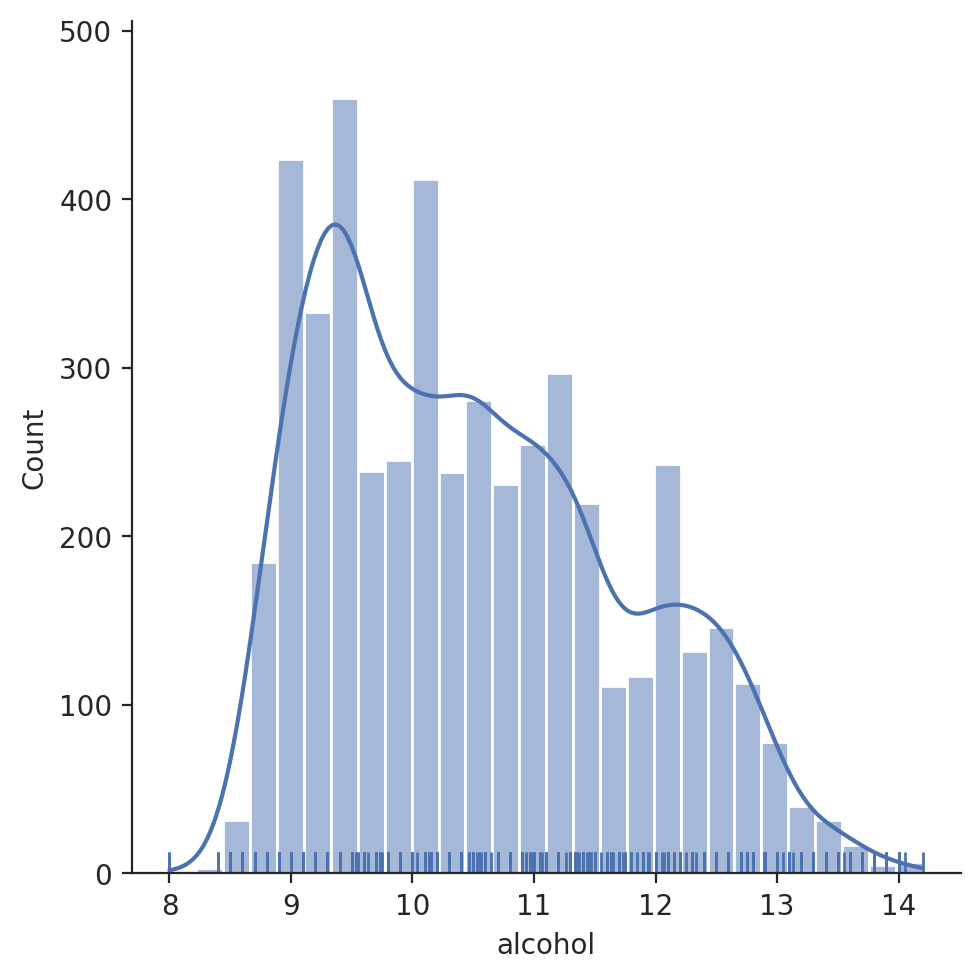

In [ ]:
sns.displot(X['alcohol'], kde=True, rug=True);

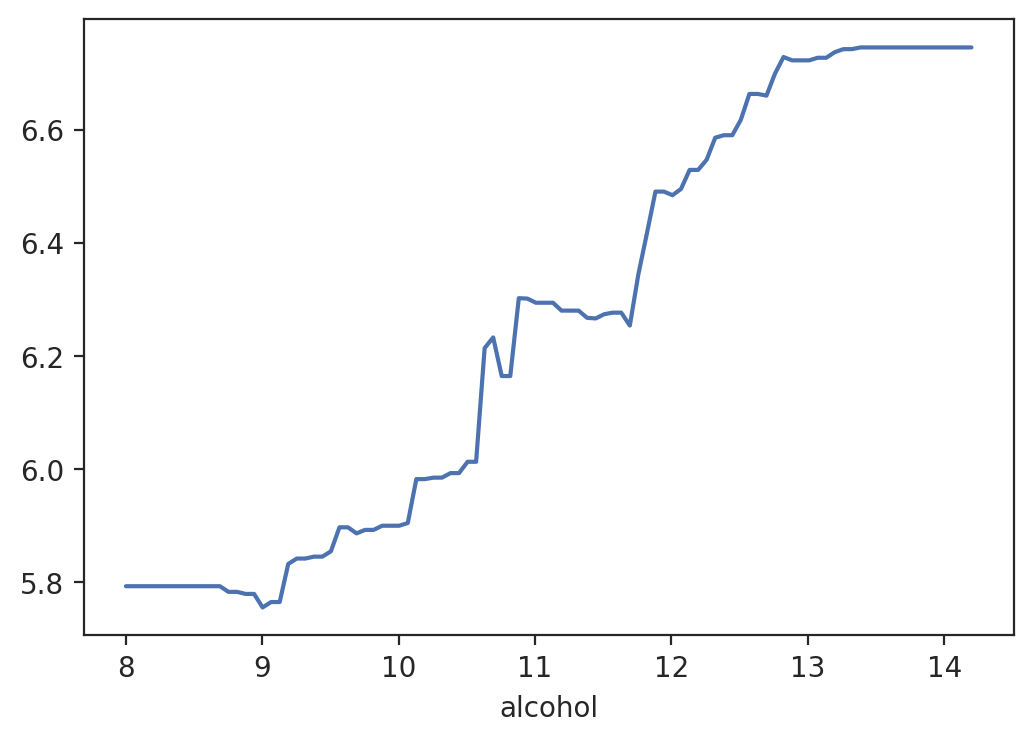

In [ ]:
ax = sns.lineplot(x=synth_df['alcohol'], y=pred);

### Partial Dependency Plot (PDP)

* Put simply, for a feature of interest (e.g., `temp`), a PDP represents the **average of all ICEs**.

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

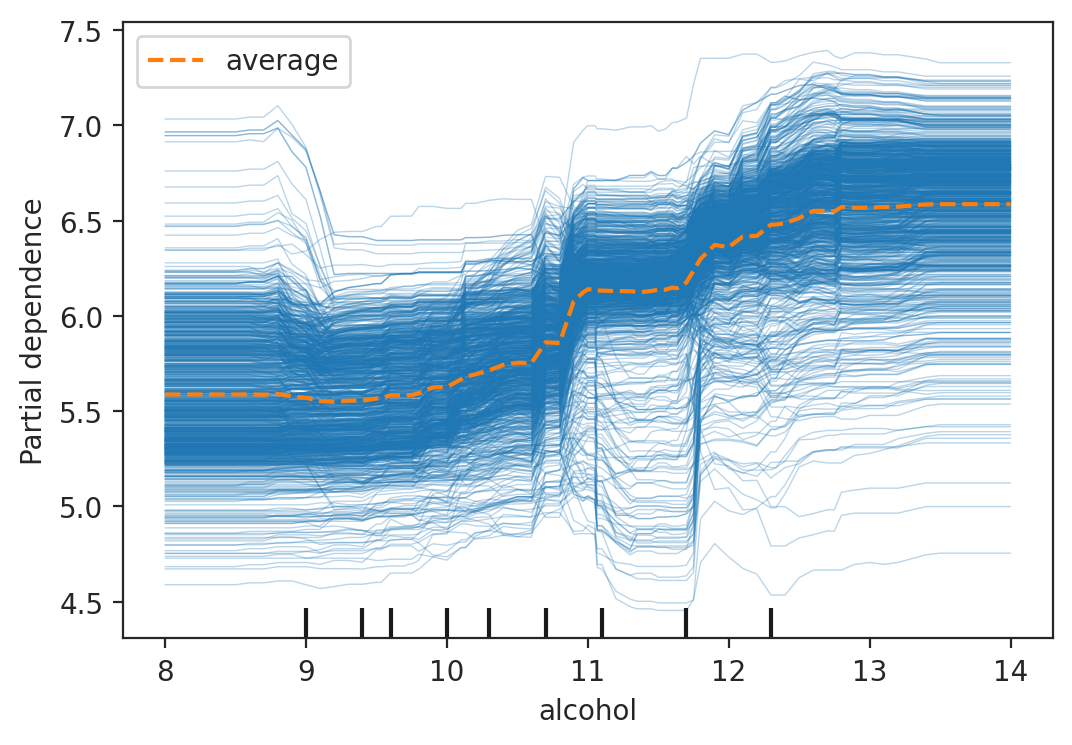

In [ ]:
PartialDependenceDisplay.from_estimator(
    rfr, X_test, features=['alcohol'], kind='both'
);

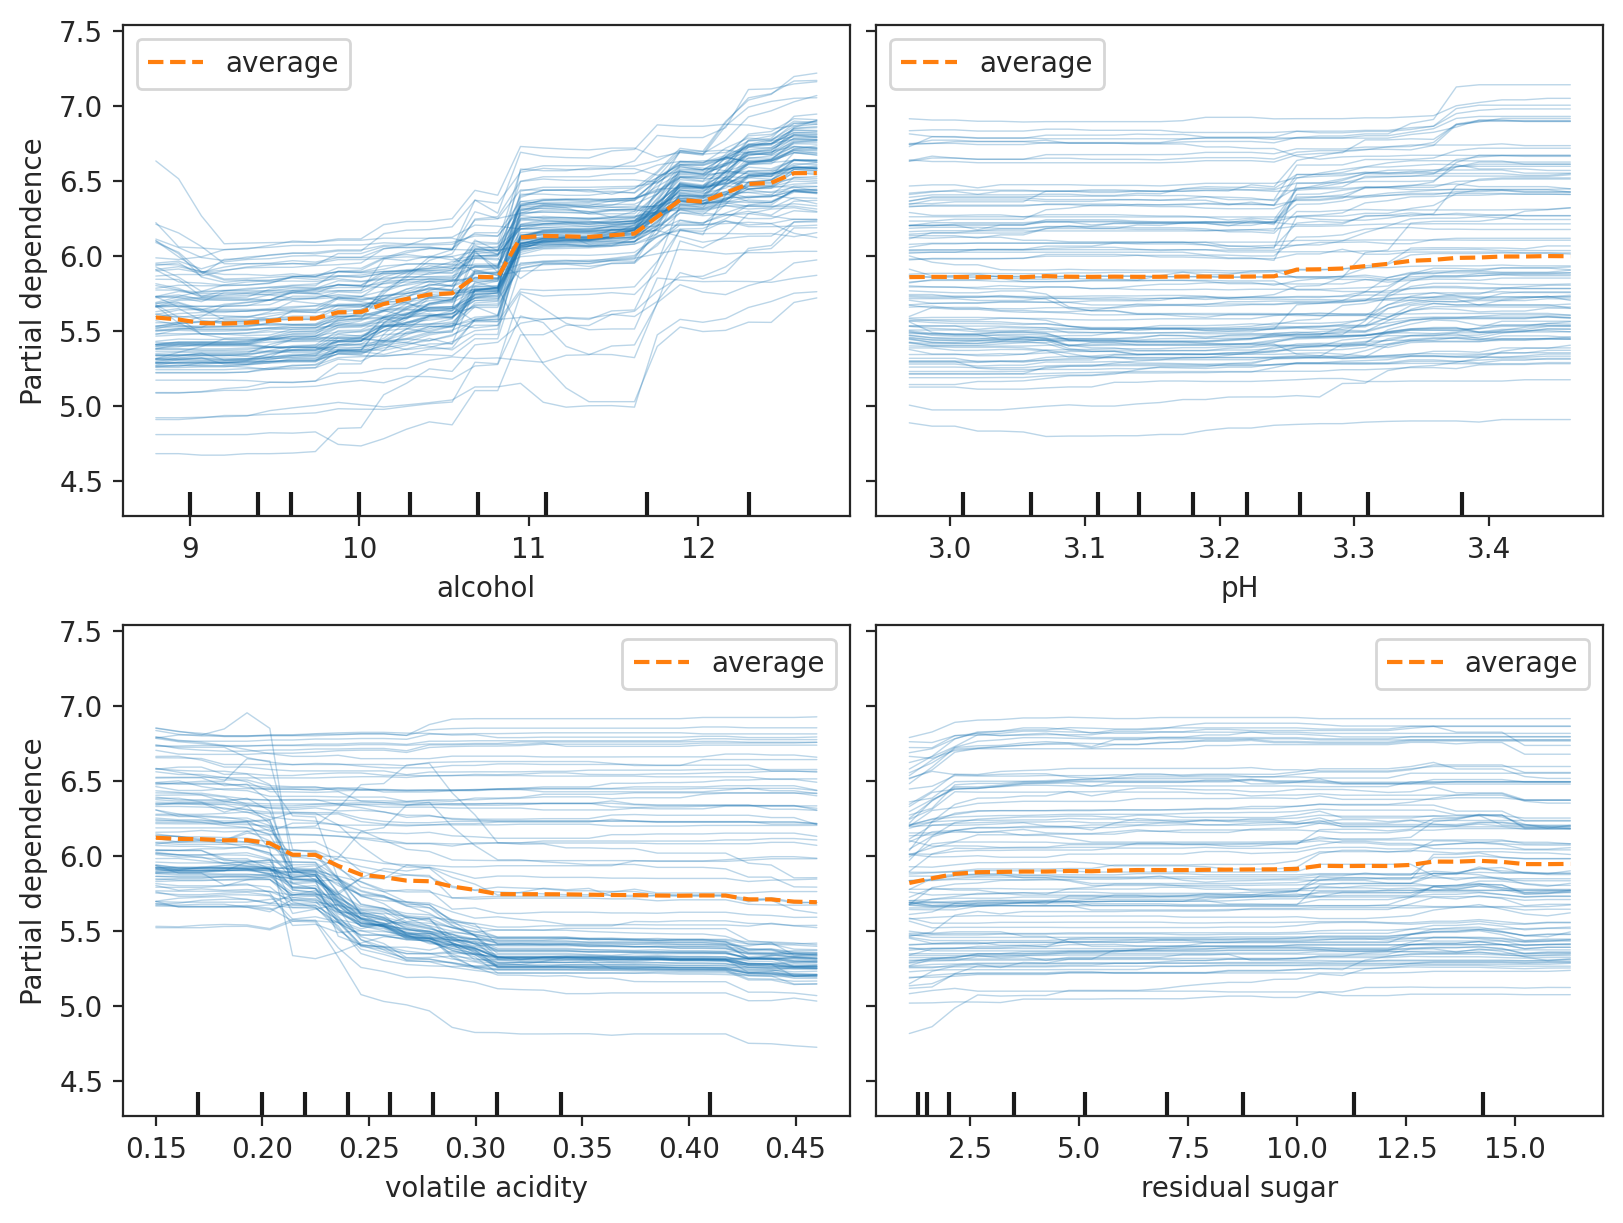

In [ ]:
fig, ax = plt.subplots(figsize=(8,6), constrained_layout=True)
PartialDependenceDisplay.from_estimator(
    rfr, X_test, features=['alcohol', 'pH', 'volatile acidity', 'residual sugar'],
    kind='both',
    subsample=100, grid_resolution=30, n_jobs=2, random_state=0,
    ax=ax, n_cols=2
);

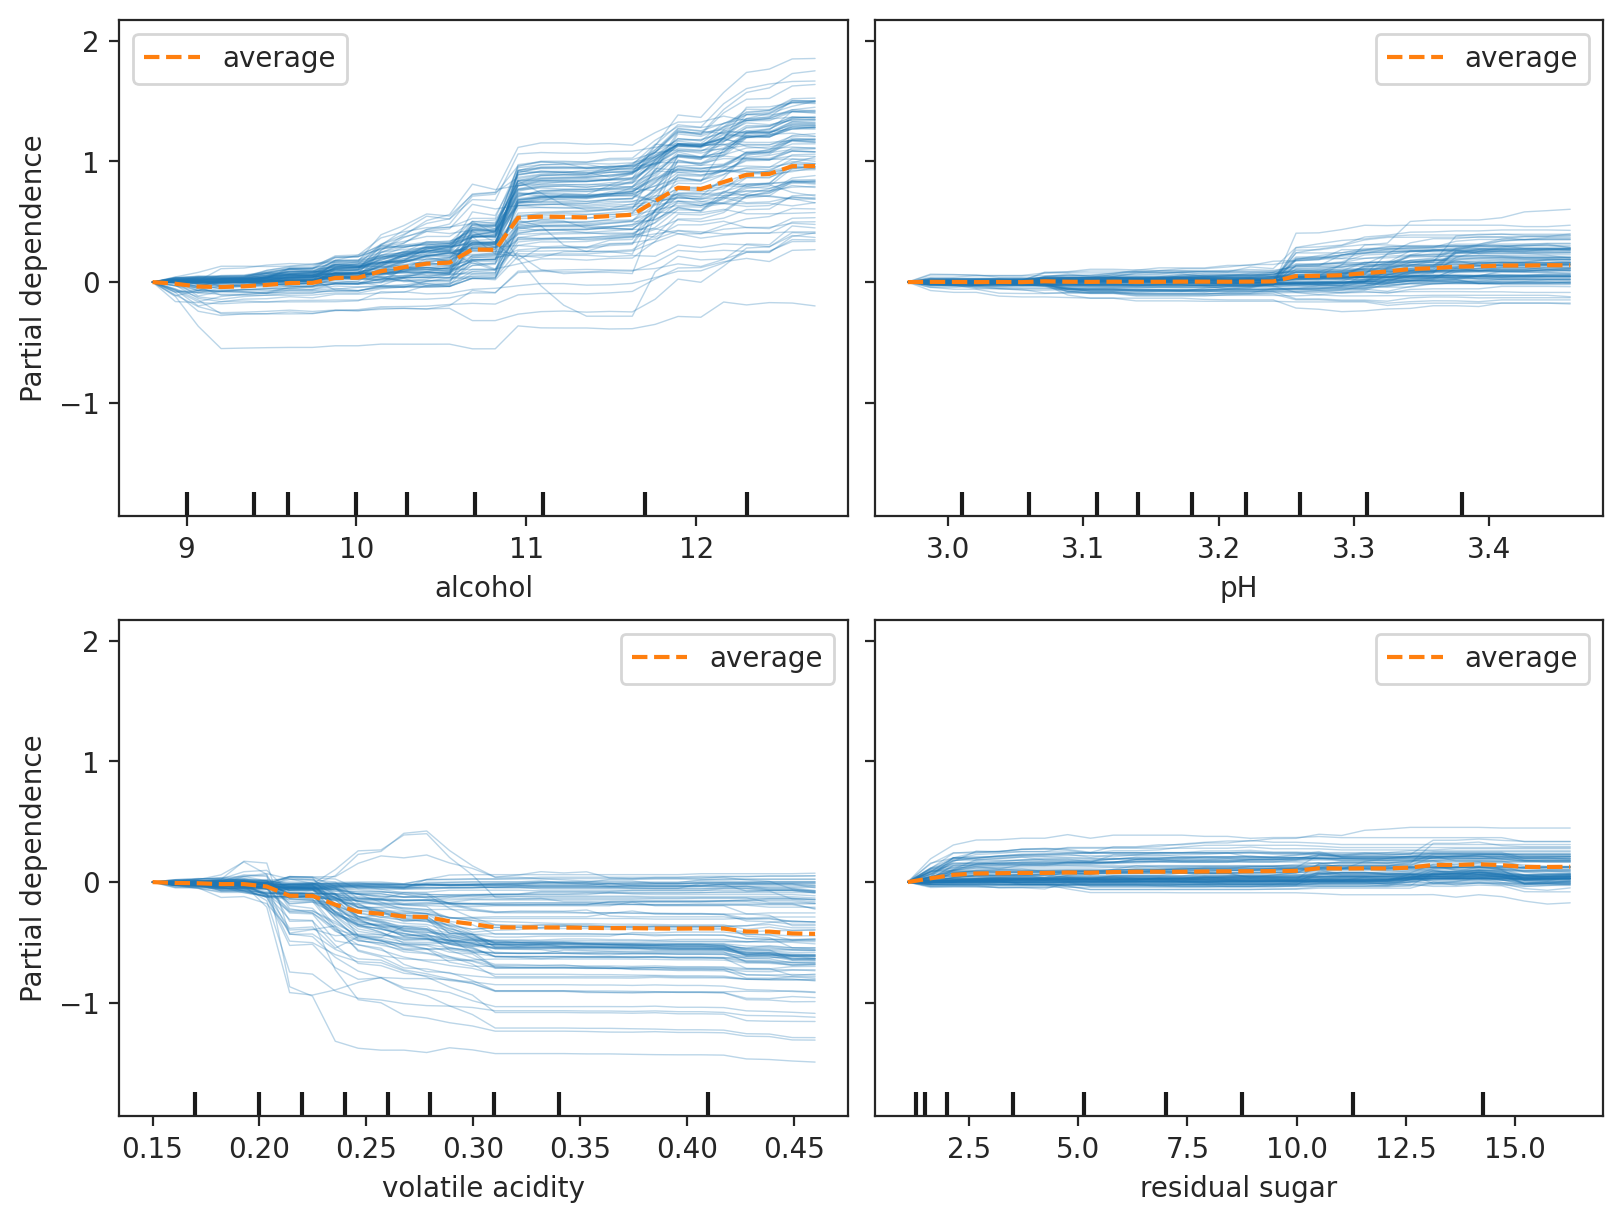

In [ ]:
fig, ax = plt.subplots(figsize=(8,6), constrained_layout=True)
PartialDependenceDisplay.from_estimator(
    rfr, X_test, features=['alcohol', 'pH', 'volatile acidity', 'residual sugar'],
    kind='both', centered=True,
    subsample=100, grid_resolution=30, n_jobs=2, random_state=0,
    ax=ax, n_cols=2
);

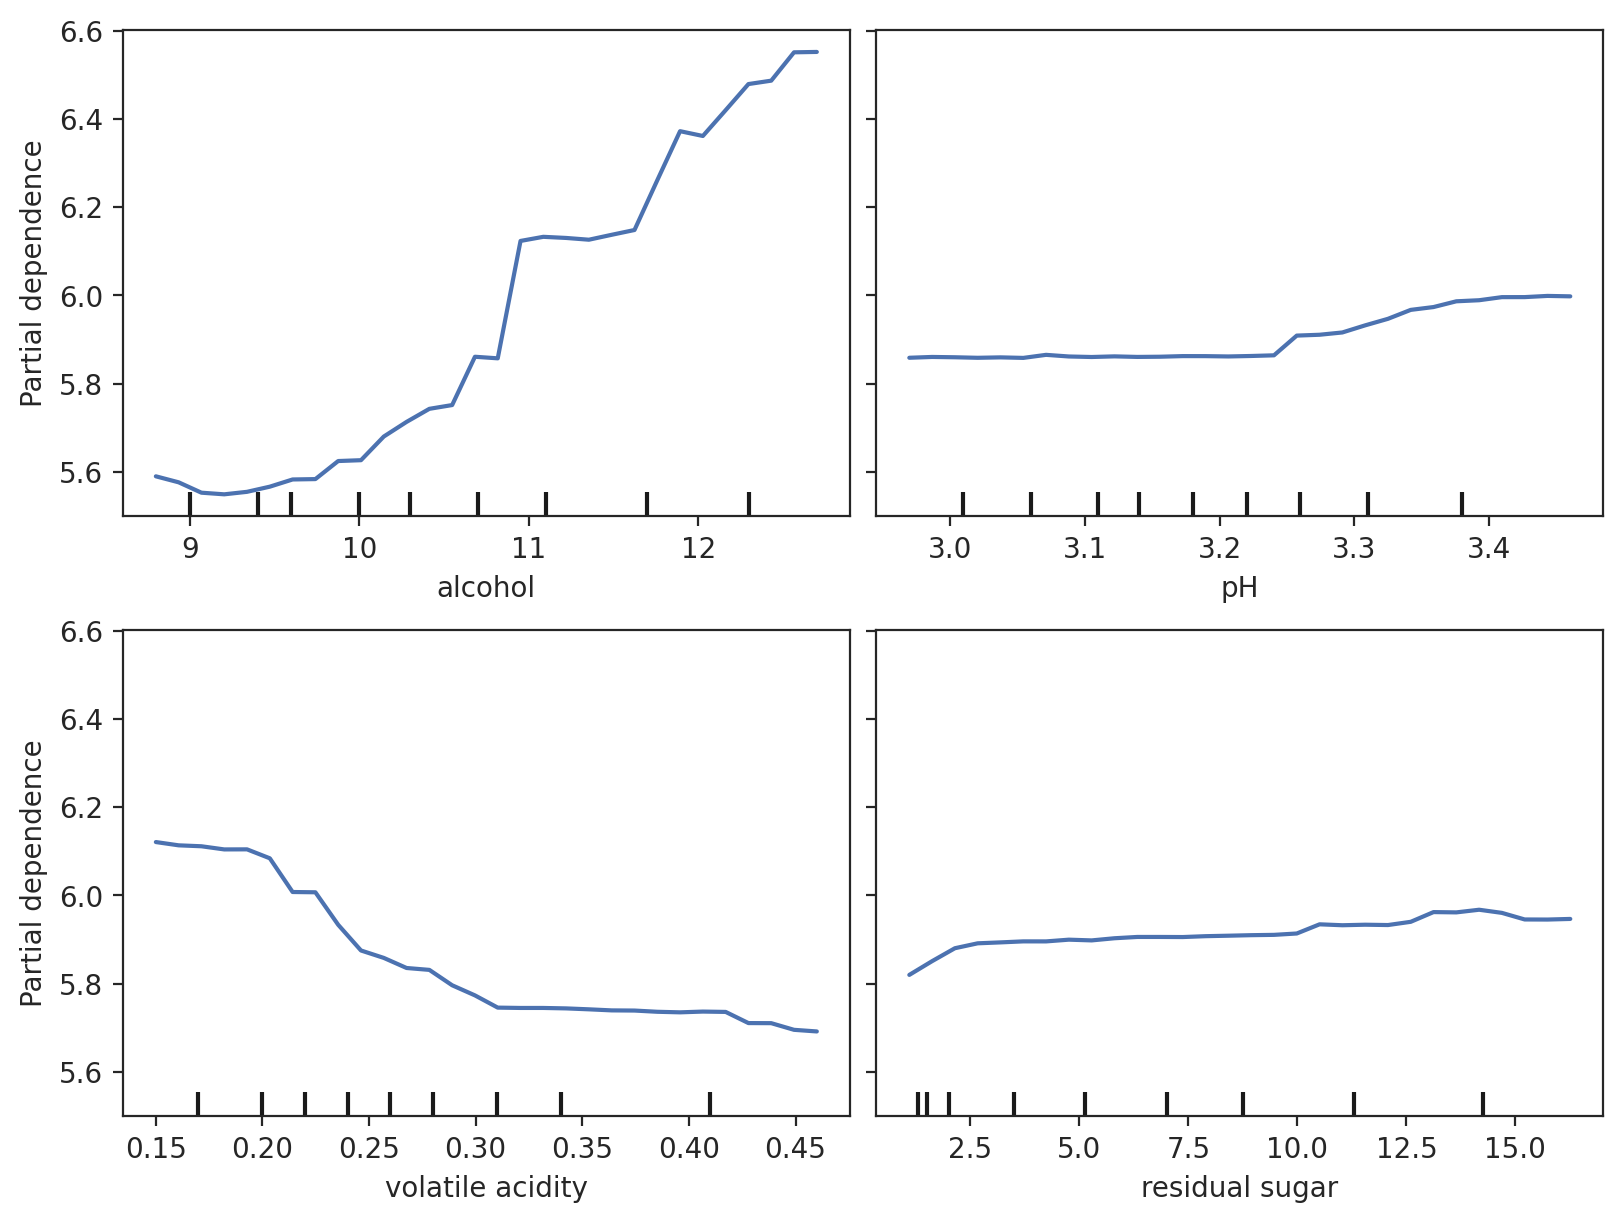

In [ ]:
fig, ax = plt.subplots(figsize=(8,6), constrained_layout=True)
PartialDependenceDisplay.from_estimator(
    rfr, X_test, features=['alcohol', 'pH', 'volatile acidity', 'residual sugar'],
    kind='average',
    subsample=100, grid_resolution=30, n_jobs=2, random_state=0,
    ax=ax, n_cols=2
);